# Examples of using velociraptor data

In [1]:
#load matplotlib as inline so figures display within the notebook
%matplotlib inline
from matplotlib.pylab import *
rcParams['figure.figsize'] = (10,6)
rcParams['font.size'] = 18

In [2]:
#load other useful packages
import numpy as np
import astropy as ap
import pynbody as pyn
#for general python stuff
import sys,os,string,time,re,struct
import math,operator
#for useful scipy stuff
from scipy.stats.mstats import mquantiles
from scipy.misc import comb
import scipy.interpolate as scipyinterp
import scipy.integrate as scipyint
import scipy.optimize as scipyopt
import scipy.special as scipysp
import itertools
#for useful mathematical tools
from sklearn.neighbors import NearestNeighbors
import scipy.spatial as spatial

#to load specific functions defined in another python file
basecodedir='/dir/to/'
sys.path.append(basecodedir+'/VELOCIraptor-STF/stf/tools/')
import velociraptor_python_tools as vpt

## Loading Halos

In [3]:
#define formats
ASCIIFORMAT=0
HDFFORMAT=2

#base filename 
inputfname="basevelociraptorfilename"

In [4]:
#now we try loading halo property data
halopropdata,numhalos=vpt.ReadPropertyFile(inputfname,HDFFORMAT)

In [5]:
#then load the particles associated with halos
haloparticledata=vpt.ReadParticleDataFile(inputfname,HDFFORMAT)

In [6]:
#list the keys available
print(halopropdata.keys())
print(halopropdata['SimulationInfo'].keys())
print(halopropdata['UnitInfo'].keys())
print(haloparticledata.keys())

dict_keys(['RVmax_eig_xy', 'eig_yz', 'RVmax_Lx', 'eig_yx', 'RVmax_eig_xz', 'veldisp_yx_gas', 'Xc_gas', 'R_size', 'veldisp_xy_gas', 'sigV', 'Zcmbp', 'veldisp_yz', 'ID', 'veldisp_zx_gas', 'Lz', 'RVmax_eig_zx', 'eig_zy', 'eig_zx_gas', 'veldisp_xx_gas', 'veldisp_zz', 'RVmax_veldisp_yy', 'veldisp_zy_gas', 'T_gas', 'RVmax_eig_zz', 'npart', 'lambda_B', 'R_BN97', 'Efrac_gas', 'RVmax_eig_zy', 'Zc_gas', 'RVmax_veldisp_zy', 'SimulationInfo', 'eig_yx_gas', 'VXc', 'veldisp_yy_gas', 'RVmax_veldisp_xz', 's_gas', 'Ycmbp', 'M_gas_500c', 'VYc_gas', 'Ly', 'Epot', 'Ly_gas', 'eig_zz_gas', 'eig_xz', 'RVmax_veldisp_zx', 'R_200mean', 'VXcmbp', 'eig_xz_gas', 'eig_zy_gas', 'M_gas_30kpc', 'RVmax_veldisp_zz', 'UnitInfo', 'RVmax_lambda_B', 'VXc_gas', 'Zc', 'RVmax_Ly', 'VZc', 'veldisp_xz_gas', 'veldisp_zy', 'veldisp_zz_gas', 'veldisp_xy', 'veldisp_yz_gas', 'q_gas', 'veldisp_xz', 'veldisp_xx', 'ID_mbp', 'RVmax_s', 'veldisp_zx', 'R_HalfMass', 'Xcmbp', 'Mass_tot', 'q', 'RVmax_eig_yy', 'RVmax_eig_yx', 's', 'Yc_gas', 'E

## Plotting halo mass function

In [7]:
#Set bin edges (log M)
NBINS=50
xlim=[5,15]
xlim=[0,5]
deltax=(xlim[1]-xlim[0])/float(NBINS)
xedges=np.arange(xlim[0],xlim[1]+0.5*deltax,deltax)
xbins=np.arange(xlim[0]+0.5*deltax,xlim[1],deltax)

#desired mass field
massfield=['Mass_200crit','Mass_tot', 'Mass_200mean']
massbindata=dict()
#make histograms while converting units to Msun and kpc
for key in massfield:
    massfac=np.log10(halopropdata['UnitInfo']['Mass_unit_to_solarmass'])
    massbindata[key],blah=np.histogram(np.log10(halopropdata[key])+massfac,xedges)
    massbindata[key]=np.float64(massbindata[key])/np.power(halopropdata['SimulationInfo']['Period']/halopropdata['SimulationInfo']['h_val'],3.0)
#store mass value at which a halo is composed of 100 particles
vlinedata=halopropdata["Mass_tot"][np.where(halopropdata["npart"]==100)][0]

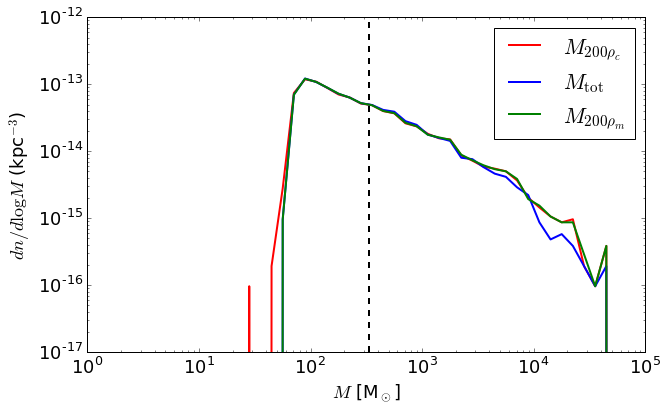

In [8]:
colors=['red','blue','green']
vlabels=[r'$M_{200\rho_c}$',r'$M_{\rm{tot}}$',r'$M_{200\rho_m}$']
for i in range(len(massfield)):
    plot(np.power(10.0,xbins),massbindata[massfield[i]],color=colors[i],label=vlabels[i],linewidth=2)
axvline(x=vlinedata,color='black',linewidth=2,linestyle='dashed')
ylabel(r'$dn/d\log M$ (kpc$^{-3}$)')
xlabel(r'$M$ [M$_\odot$]')
yscale("log")
xscale("log")
legend()

## Plotting halo versus concentration

In [9]:
#desired mass field
massfield=['Mass_200crit','Mass_tot', 'Mass_200mean']
massdata=dict()
#make histograms while converting units to Msun and kpc
sel=np.where(halopropdata['npart']>=1000)
for key in massfield:
    massfac=np.log10(halopropdata['UnitInfo']['Mass_unit_to_solarmass'])
    massdata[key]=np.power(10.0,np.log10(halopropdata[key][sel])+massfac)
cnfw=halopropdata['cNFW'][sel]

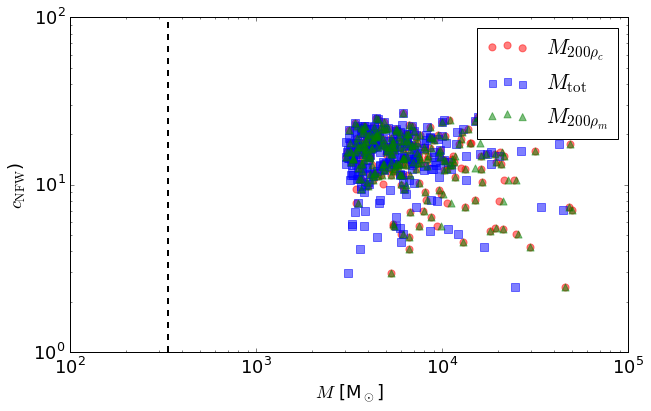

In [10]:
markerstyle=['o','s','^']

for i in range(len(massfield)):
    scatter(massdata[massfield[i]],cnfw,color=colors[i],label=vlabels[i],marker=markerstyle[i],alpha=0.5,s=50)
axvline(x=vlinedata,color='black',linewidth=2,linestyle='dashed')
ylabel(r'$c_{\rm NFW}$)')
xlabel(r'$M$ [M$_\odot$]')
yscale("log")
xscale("log")
legend()